<a href="https://colab.research.google.com/github/dowrave/Tensorflow_Basic/blob/main/220517_AdvancedAutoDiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt 

mpl.rcParams['figure.figsize'] = (8, 6)

## 그래디언트 기록 제어하기
- 기록 중단하기 : `GradientTape.stop_recording()`
  - 일시 중단이 오버헤드를 줄이는 데 유용할 수 있다.

In [4]:
x = tf.Variable(2.)
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  x_sq = x * x
  with tape.stop_recording():
    y_sq = y * y
  z = x_sq + y_sq

grad = tape.gradient(z, {'x' : x, 'y' : y})

print('dz/dx : ', grad['x']) # 2x = 4
print('dz/dy : ', grad['y']) # 기록되었다면 2y = 6 이지만 None이 뜸

dz/dx :  tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy :  None


- 재시작하기 : `reset()`
- 테이프 블록 종료 후 재시작하는 것이 읽기 쉽지만 블록 종료가 어렵거나 불가능하다면 `reset`을 사용할 수 있다.

In [5]:
x = tf.Variable(2.)
y = tf.Variable(3.)
reset = True

with tf.GradientTape() as tape: # reset에 의해 y_sq 값이 기록되지 않았음을 볼 수 있음
  y_sq = y * y
  if reset:
    tape.reset()
  z = x * x + y_sq # 즉 z = x*x + None이 된 것

grad = tape.gradient(z, {'x' : x, 'y' : y})

print('dz/dx : ', grad['x']) # 2x = 4
print('dz/dy : ', grad['y']) # 기록되었다면 2y = 6 이지만 None이 뜸

dz/dx :  tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy :  None


## 그래디언트 중지
- `tf.stop_gradient` - 특정 경로를 따라 그래디언트가 흐르는 것을 막을 수 있다.

In [6]:
x = tf.Variable(2.)
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  y_sq = y ** 2
  z = x ** 2 + tf.stop_gradient(y_sq)

grad = tape.gradient(z, {'x' : x, 'y' : y})

# 2x에 대해서만 반응, y_sq는 반응 x
print('dz/dx : ', grad['x'])  
print('dz/dy : ', grad['y']) 

dz/dx :  tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy :  None


## 사용자 정의 그래디언트
- 사용하는 경우는 이런 것들이 있겠다.
1. 작성 중인 op에 대해 정의된 그래디언트가 없다.
2. 기본 계산이 수치적으로 불안정하다.
3. 정방향 패스에서 값비싼 계산을 캐시하려 한다
4. 그래디언트를 수정하지 않고 값(`tf.clip_by_value, tf.math_round`)을 수정하려 한다.

- 새로운 op를 작성하려면 `tf.RegisterGradient`를 사용할 수 있다.
- 2~4의 경우는 `tf.custom_gradient`를 사용할 수 있다.


In [7]:
@tf.custom_gradient
def clip_gradients(y):
  def backward(dy):
    return tf.clip_by_norm(dy, 0.5)
  return y, backward

v = tf.Variable(2.)
with tf.GradientTape() as tape:
  output = clip_gradients(v * v)
print(tape.gradient(output, v)) 

tf.Tensor(2.0, shape=(), dtype=float32)


`tf.clip_by_norm` : `tensor * clip_norm / L2norm(tensor)`

## 여러 테이프의 상호작용

In [13]:
x0 = tf.constant(0.)
x1 = tf.constant(0.)

with tf.GradientTape() as tape0, tf.GradientTape() as tape1:
  tape0.watch(x0)
  tape1.watch(x1)

  y0 = tf.math.sin(x0)
  y1 = tf.nn.sigmoid(x1)

  y = y0 + y1

  ys = tf.reduce_sum(y)

In [14]:
print(tape0.gradient(ys, x0).numpy()) # cos(x) = 1.
print(tape1.gradient(ys, x1).numpy())

1.0
0.25


- 고계도(2번, 3번, 4번 미분..) 그래디언트에도 똑같이 작동한다.

In [16]:
x = tf.Variable(1.)

with tf.GradientTape() as t2:
  with tf.GradientTape() as t1:
    y = x * x * x

  dy_dx = t1.gradient(y, x)
d2y_dx2 = t2.gradient(dy_dx, x)

print(dy_dx.numpy())  # 3x^2 = 3
print(d2y_dx2.numpy()) # 6x = 6

3.0
6.0


# 적대적 예시에 대응하기
- 대응 : 입력 그래디언트 정규화 -> 입력 그래디언트의 크기를 최소화하려고 함
- 구현
1. 내부 테이프로 입력에 대한 출력 그래디언트를 계산.
2. 해당 입력 그래디언트의 크기 계산
3. 모델에 대한 해당 크기의 그래디언트 계산

In [17]:
x = tf.random.normal([7, 5])
layer = tf.keras.layers.Dense(10, activation = tf.nn.relu) 

In [18]:
with tf.GradientTape() as t2:
  # 내부 테이프는 input에 대한 그래디언트만을 취함 : Variable은 해당 없음
  with tf.GradientTape(watch_accessed_variables = False) as t1:
    t1.watch(x)
    y = layer(x)
    out = tf.reduce_sum(layer(x) ** 2)
  # 1. input gradient 계산
  g1 = t1.gradient(out, x)

  # 2. input gradient의 크기(magnitude) 계산 - 이 부분이 근본적으로 다름 : 원래는 g1을 가중치 각각에 반영하는 식으로 진행됨
  g1_mag = tf.norm(g1) # 기본 : 유클리디언

# 3. 모델에 대해 그래디언트 크기 계산
dg1_mag = t2.gradient(g1_mag, layer.trainable_variables) # 모든 Varaible에 대한 그래디언트 값이 계산됨

In [19]:
[var.shape for var in dg1_mag]

[TensorShape([5, 10]), TensorShape([10])]

# Jacobian
- 이전 예제들은 소스 텐서에 대해 스칼라의 그래디언트
- 여기부터는 <b>벡터값 함수의 그래디언트</b>
- `GradientTape.jacobian` 메소드로 자코비안 행렬식을 효율적으로 계산할 수 있다.
- 참고
  - `gradient` 처럼 `source` 인수는 텐서나 텐서의 컨테이너가 될 수 있다.
  - `gradient`와 달리 `target` 텐서는 단일 텐서


In [20]:
# 1. 스칼라 소스
x = tf.linspace(-10., 10., 200 + 1)
delta = tf.Variable(0.)

with tf.GradientTape() as tape:
  y = tf.nn.sigmoid(x + delta)

dy_dx = tape.jacobian(y, delta)

In [21]:
print(y.shape)
print(dy_dx.shape)

(201,)
(201,)


Text(0.5, 0, 'x')

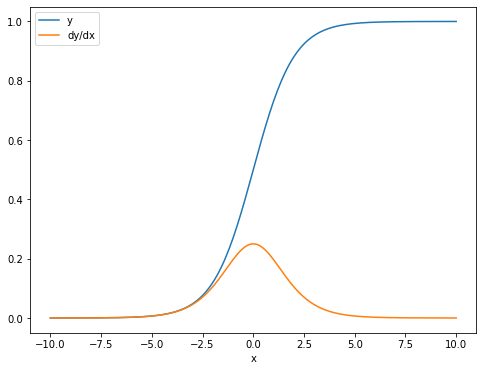

In [22]:
plt.plot(x.numpy(), y, label = 'y')
plt.plot(x.numpy(), dy_dx, label = 'dy/dx')
plt.legend()
plt.xlabel('x')

In [23]:
# 2. 텐서 소스 - 결과 shape는 항상 input의 shape를 따른다.
x = tf.random.normal([7, 5])
layer = tf.keras.layers.Dense(10, activation = 'relu')

with tf.GradientTape(persistent = True) as tape:
  y = layer(x)

y.shape

TensorShape([7, 10])

In [24]:
layer.kernel.shape # kernel = weight matrix

TensorShape([5, 10])

In [25]:
# 커널에 대한 출력의 Jacobian Shape는 서로 연결된 2가지 형상이다.
j = tape.jacobian(y, layer.kernel)
j.shape

TensorShape([7, 10, 5, 10])

In [27]:
# 차원을 합치면 GradientTape.gradient에서 계산한 합계 그래디언트가 남는다.
g = tape.gradient(y, layer.kernel)
print('g.shape : ', g.shape)

j_sum = tf.reduce_sum(j, axis = [0, 1])
delta = tf.reduce_max(abs(g - j_sum)).numpy()
assert delta < 1e-3
print('delta : ', delta)

g.shape :  (5, 10)
delta :  2.3841858e-07


### Hessian
- `tf.GradientTape`에서 Hessian 행렬 구성하는 방법을 제공하지는 않지만, `GradientTape.jacobian` 메서드로 빌드할 수 있다.
- `N**2` 매개변수를 포함하며, 여러 이유로 인해 실용적이지 않다. 다음 예제는 그냥 설명 차원의 개념이며 최적화를 보증하지 않음. 중첩 테이프로 효율적으로 계산할 수 있다고 함.

In [28]:
x = tf.random.normal([7, 5])
layer1 = tf.keras.layers.Dense(8, activation = tf.nn.relu)
layer2 = tf.keras.layers.Dense(6, activation = tf.nn.relu)

with tf.GradientTape() as t2:
  with tf.GradientTape() as t1:
    x = layer1(x)
    x = layer2(x)
    loss = tf.reduce_mean(x**2)

  g = t1.gradient(loss, layer1.kernel)

h = t2.jacobian(g, layer1.kernel)


In [29]:
print(f"Layer.kernel.shape : {layer1.kernel.shape}")
print(f"h.shape : {h.shape}")

Layer.kernel.shape : (5, 8)
h.shape : (5, 8, 5, 8)


In [31]:
# ? 뭐하는 건지 모르겠는데 그냥 따라가봄
n_params = tf.reduce_prod(layer1.kernel.shape)

g_vec = tf.reshape(g, [n_params, 1])
h_mat = tf.reshape(h, [n_params, n_params])

In [32]:
# Hessian 행렬은 대칭이어야 함
def imshow_zero_center(image, **kwargs):
  lim = tf.reduce_max(abs(image))
  plt.imshow(image, vmin = -lim, vmax = lim, cmap = 'seismic', **kwargs)
  plt.colorbar()


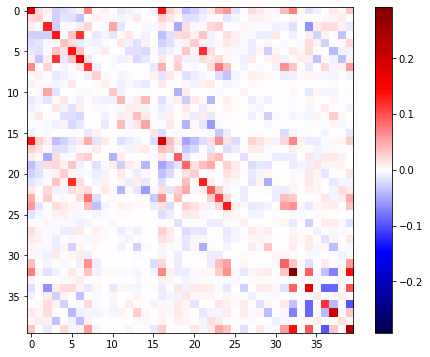

In [33]:
imshow_zero_center(h_mat)

In [34]:
# 뉴턴 업데이트
eps = 1e-3
eye_Eps = tf.eye(h_mat.shape[0]) * eps # tf.eye : build identity Matrix

In [35]:
update = tf.linalg.solve(h_mat + eye_Eps, g_vec) # tf.linalg : 선형식에 대한 모듈

_ = layer1.kernel.assign_sub(tf.reshape(update, layer1.kernel.shape))

## Batch Jacobian

In [37]:
x = tf.random.normal([7, 5]) # (batch, ins)

layer1 = tf.keras.layers.Dense(8, activation = tf.nn.relu)
layer2 = tf.keras.layers.Dense(6, activation = tf.nn.relu)

with tf.GradientTape(persistent = True, watch_accessed_variables = False) as tape:
  tape.watch(x)
  y = layer1(x)
  y = layer2(y) # (batch, outs)

y.shape

TensorShape([7, 6])

In [38]:
# x에 대한 y의 전체 야고비안은 (batch, ins, outs)만 원하는 경우에도 (batch, ins, batch, outs)의 shape를 가짐
j = tape.jacobian(y,x)
j.shape

TensorShape([7, 6, 7, 5])

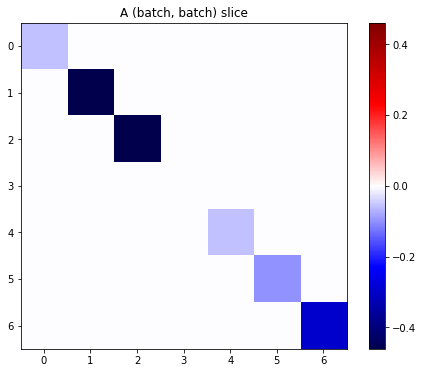

In [39]:
# 스택의 각 항목의 그래디언트가 독립적이라면 모든 (batch, batch) 슬라이스는 독립적이다
imshow_zero_center(j[:, 0, :, 0])
_ = plt.title('A (batch, batch) slice')

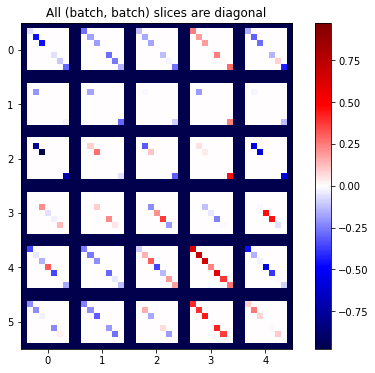

In [41]:
def plot_as_patches(j):
  j = tf.transpose(j, [1, 0, 3, 2])
  lim = tf.reduce_max(abs(j))
  j = tf.pad(j, [[0,0], [1,1], [0,0], [1,1]], constant_values = -lim)

  s = j.shape
  j = tf.reshape(j, [s[0]* s[1], s[2] * s[3]])
  imshow_zero_center(j, extent=[-0.5, s[2]-0.5, s[0]-0.5, -0.5])

plot_as_patches(j)
_ = plt.title('All (batch, batch) slices are diagonal')

In [42]:
# 원하는 결과를 얻으려면 중복 batch 차원을 합산하거나 tf.einsum을 사용해 대각선을 선택할 수 있다.
j_sum = tf.reduce_sum(j, axis = 2)
print(j_sum.shape)
j_select = tf.einsum('bxby->bxy', j)
print(j_select.shape)

(7, 6, 5)
(7, 6, 5)


In [43]:
# 처음부터 추가 차원 없이 계싼 수행하는 게 더 효율적이다 : `GradientTape.batch_jacobian` 메소드
jb = tape.batch_jacobian(y, x)
jb.shape

TensorShape([7, 6, 5])

In [44]:
# GradientTape.batch_jacobian은 1번째 차원만 일치하는지 확인하고 그래디언트가 실제로 독립인지 확인하지 않는다.
# 언제 쓸 것인가는 사용자에게 달려 있음
# 예를 들어 layers.BatchNormalization을 추가하면 정규화되므로 독립성이 없어짐
x = tf.random.normal([7, 5])

layer1 = tf.keras.layers.Dense(8, activation = tf.nn.elu)
bn = tf.keras.layers.BatchNormalization()
layer2 = tf.keras.layers.Dense(6, activation = tf.nn.elu)

with tf.GradientTape(persistent = True, watch_accessed_variables = False) as tape:
  tape.watch(x)
  y = layer1(x)
  y = bn(y, training = True)
  y = layer2(y)

j = tape.jacobian(y, x)
print(f'j.shape : {j.shape}')

j.shape : (7, 6, 7, 5)


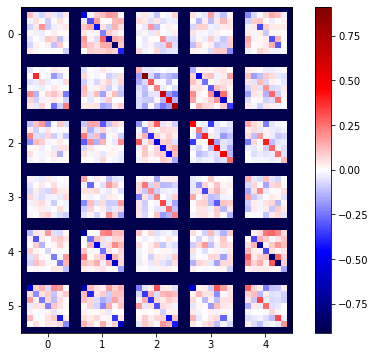

In [45]:
plot_as_patches(j) # Diagonal 행렬이 아니죠? 그러나 batch_jacobian은 여전히 실행되는 걸 볼 수 있음

In [46]:
jb = tape.batch_jacobian(y, x)
print(f"jb.shape : {jb.shape}")

jb.shape : (7, 6, 5)
